# 1. MNISTを用いた文字認識（MLP）


---
## 目的
多層パーセプトロン（MLP）を用いてMNISTデータセットに対する文字認識を行う．
評価はConfusion Matrixにより各クラスの認識率を用いて行う．

## 使用するデータセット
今回の文字認識では，MNIST Datasetを用いる．[MNIST Dataset](http://yann.lecun.com/exdb/mnist/)は，0から9までの数字が記述されている画像から構成されたデータセットである．MNIST Datasetの文字画像は，以下のように白黒で比較的認識しやすいように画像処理されている．

![MNIST_sample.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/143078/559938dc-9a99-d426-010b-e000bca0aac6.png)

## モジュールのインポート
はじめに必要なモジュールをインポートする．

今回は`torch` (PyTorch) をインポートする．

In [1]:
from time import time
import numpy as np
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import torchsummary

## データセットの読み込みと確認
学習データ（MNIST Dataset）を読み込みます．

読み込んだ学習データのサイズを確認します．
学習データ数は6万枚，評価データは1万枚，1つのデータのサイズは28x28の786次元となっています．

In [2]:
train_data = torchvision.datasets.MNIST(root="./", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST(root="./", train=False, transform=transforms.ToTensor(), download=True)

print(type(train_data.data), type(train_data.targets))
print(type(test_data.data), type(test_data.targets))
print(train_data.data.size(), train_data.targets.size())
print(test_data.data.size(), test_data.targets.size())

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([10000, 28, 28]) torch.Size([10000])


### MNISTデータセットの表示

MNISTデータセットに含まれる画像を表示してみます．
ここでは，matplotlibを用いて複数の画像を表示させるプログラムを利用します．

<Figure size 432x288 with 0 Axes>

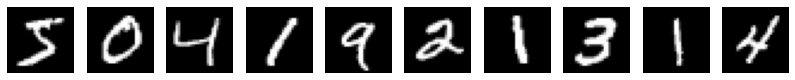

In [3]:
import matplotlib.pyplot as plt

cols = 10

plt.clf()
fig = plt.figure(figsize=(14, 1.4))
for c in range(cols):
    ax = fig.add_subplot(1, cols, c + 1)
    ax.imshow(train_data[c][0].view(28, 28), cmap=plt.get_cmap('gray'))
    ax.set_axis_off()
plt.show()

## ネットワークモデルの定義

ニューラルネットワークを定義します．
ここでは，入力層，中間層，出力層から構成される３層のニューラルネットワークとします．

入力層のユニット数は入力データのサイズによります．
ここでは`28 x 28 = 786`とし，画像の画素値を1次元配列として並べ替えたデータを入力するように指定します．

中間層と出力層のユニット数は引数として与え，それぞれ`n_hidden`，`n_out`とします．
PyTorchでは，`__init__`関数にこれらの引数を与えて各層を定義します．
各層はLinear関数としています．これは全結合層を意味しています．
また，`self.act`で活性化関数を指定します．ここでは，シグモイド関数を活性化関数として指定します．

そして，`forward`関数で定義した層を接続して処理するように記述します．
`forward`関数の引数`x`は入力データを示しています．
それを`forward`関数で定義した`l1`という中間層および活性化関数`act`へ順番に入力します．
その出力を`h1`としています．
`h1`は出力層`l2`に与えられ，その出力を`h2`としています．

In [4]:
class MLP(nn.Module):
    def __init__(self, n_hidden, n_out):
        super().__init__()
        self.l1 = nn.Linear(28*28, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_out)
        self.act = nn.Sigmoid()
        
    def forward(self, x):
        h1 = self.act(self.l1(x))
        h2 = self.l2(h1)
        return h2

## ネットワークの作成
上のプログラムで定義したネットワークを作成します．

まず，中間層と出力層のユニット数を定義します．
ここでは，中間層のユニット数`hidden_num`を16，出力層のユニット数`out_num`をMNISTのクラス数に対応する10とします．

各層のユニット数を上で定義した`MLP`クラスの引数として与え，ネットワークモデルを定義します．

学習を行う際の最適化方法としてモーメンタムSGD(モーメンタム付き確率的勾配降下法）を利用します．
また，学習率を0.01，モーメンタムを0.9として引数に与えます．

最後に，定義したネットワークの詳細情報を`torchsummary.summary()`関数を用いて表示します．第一引数に詳細を表示したいモデル，第二引数にネットワークへ入力されるデータのサイズを指定します．
これによって，ネットワークの構造を確認することができます．

In [5]:
# ユニット数の定義
hidden_num = 16
out_num = 10

# ネットワークの作成
model = MLP(n_hidden=hidden_num, n_out=out_num)

# 最適化手法の設定
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 定義したモデルの情報を表示
torchsummary.summary(model, (1, 28*28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 16]          12,560
           Sigmoid-2                [-1, 1, 16]               0
            Linear-3                [-1, 1, 10]             170
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


## 学習
読み込んだMNISTデータセットと作成したネットワークを用いて，学習を行います．

1回の誤差を算出するデータ数（ミニバッチサイズ）を100，学習エポック数を10とします．

次にデータローダーを定義します．
データローダーでは，上で読み込んだデータセット（`train_data`）を用いて，for文で指定したミニバッチサイズでデータを読み込むオブジェクトを作成します．
この時，`shuffle=True`と設定することで，読み込むデータを毎回ランダムに指定します．

次に，誤差関数を設定します．
今回は，分類問題をあつかうため，クロスエントロピー誤差を計算するための`CrossEntropyLoss`を`criterion`として定義します．

学習を開始します．

各更新において，学習用データと教師データをそれぞれ`image`と`label`とします．
学習モデルにimageを与えて各クラスの確率yを取得します．
各クラスの確率yと教師ラベルtとの誤差を`criterion`で算出します．
また，認識精度も算出します．
そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．

In [ ]:
# ミニバッチサイズ・エポック数の設定
batch_size = 100
epoch_num = 10

# データローダーの設定
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 誤差関数の設定
criterion = nn.CrossEntropyLoss()

# ネットワークを学習モードへ変更
model.train()

# 学習の実行
for epoch in range(1, epoch_num+1):
    sum_loss = 0.0
    count = 0
    
    for image, label in train_loader:
        image = image.view(image.size()[0], -1)
        y = model(image)
        
        loss = criterion(y, label)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        
        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

    print("epoch:{}, mean loss: {}, mean accuracy: {}".format(epoch, sum_loss/600, count.item()/60000.))

epoch:1, mean loss: 1.3797618156671525, mean accuracy: 0.6778166666666666


## テスト

学習したネットワークを用いて，テストデータに対する認識率の確認を行います．

`model.eval()`を適用することで，ネットワーク演算を評価モードへ変更します．
これにより，学習時と評価時で挙動が異なる演算（dropout等）を変更することが可能です．
また，`torch.no_grad()`を適用することで，学習時には必要になる勾配情報を保持することなく演算を行います．

In [ ]:
# データローダーの準備
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)

# ネットワークを評価モードへ変更
model.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for image, label in test_loader:
        image = image.view(image.size()[0], -1)
        y = model(image)

        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

print("test accuracy: {}".format(count.item() / 10000.))

## 課題

### 1. ネットワークの構造を変更し，認識精度の変化を確認しましょう．

**ヒント：ネットワーク構造の変更としては，次のようなものが考えられます．**
* 中間層のユニット数
* 層の数
* 活性化関数
  * `nn.Tanh()`や`nn.ReLU()`などが考えられます．
  * その他のPyTorchで使用できる活性化関数は[こちらページ](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)にまとめられています．

※ ネットワーク構造を変更した際には，`torchsummary.summary(***)`を使用し，ネットワーク構造を変更した際のパラメータ数の変化を確認してみましょう．


### 2. 学習の設定を変更し，認識精度の変化を確認しましょう．

**ヒント：プログラムの中で変更で切る設定は次のようなものが存在します．**
* ミニバッチサイズ
* 学習回数（Epoch数）
* 学習率
* 最適化手法
  * PyTorchで使用できる最適化手法は[こちらのページ](https://pytorch.org/docs/stable/optim.html#algorithms)にまとめられています．
  
